*The codes were developed on Windows 10, and were not tested on other machines. Anaconda 5.2.0 is chosen as a Python interpreter.*

This notebook introduces the concept and methodology of generating variograms.

# Spatial Data Simulation

Let's say that you are a spatial data analyst of a gold mining company, and want to know the distribution of gold percentage over 100m x 100m mining area. To understand the characteritics of the rock formations, you take 100 random rock samples from the mining area, but obviously these 100 data points are not enough to estimate gold percentage over every single spatial locations in the area. So you analyze the available data (100 rock samples from random locations) and simulate full 2D-surface plot for gold percentage over the mining area.

![Simulation](https://github.com/aegis4048/Petroleum_Engineering/blob/master/Data%20Analysis/img/gold_transform.png?raw=true)

This 2D surface simulation from sparse spatial data is a sequential process that involves many complicated statistical techniques. 

Steps:

1. Plot variogram
2. Fit variogram model
3. Apply kriging
4. Apply simulation on top of Kriging
5. Run simulation multiple times and perform additioanl data analyses as needed

In this post, the concepts, theory, and methodology of plotting a **variogram** will be covered. 


# Basics of Variograms

> **Variogram** is a measure of dissimilarity over a distance. It shows how two data points are correlated from a spatial perspective, and provides useful insights when trying to estimate the value of an unknown location using collected sample data from other locations.

[Tobler's first law of geography](https://en.wikipedia.org/wiki/Tobler%27s_first_law_of_geography) states that "everything is related to everything else, but near things are more related than distant things." Variogram demonstates just that. It shows how correlation between two spatial data varies over distances. For example, terrains 1 km apart from each other are more likely to be similar than terrains 100 km apart from each other. Oil wells 500 ft apart from each other are more likely to show similar reservoir characteristics than oil wells 5000 ft apart from each other. 


In [44]:
import pandas as pd
import numpy as np
import scipy
import matplotlib.pyplot as plt
import matplotlib.gridspec as gridspec
import math
%matplotlib notebook

In [3]:
data = pd.read_excel('sample_data/2D_Data.xlsx', sheet_name="variogram_sample")

In [11]:
x = data['x']
y = data['y']
z = data['z']

def calc_1D_distance(_data):
    num_data = len(_data)
    matrix = []
    for i in range(num_data):
        line = []
        for j in range(num_data):
            var = _data[i] - _data[j]
            line.append(var)
        matrix.append(line)
    return pd.DataFrame(data=matrix)

def calc_2D_distance(_x, _y):
    
    assert (len(_x) == len(_y)), "x and y coordinates must have the same dimension"
    
    num_data = len(_x)
    matrix = []
    for i in range(num_data):
        line = []
        for j in range(num_data):
            var = math.sqrt((_x[i] - _x[j])**2 + (_y[i] - _y[j])**2)
            line.append(var)
        matrix.append(line)
    return pd.DataFrame(matrix)

def calc_azimuth(_x, _y):
    
    assert (len(_x) == len(_y)), "x and y coordinates must have the same dimension"
    
    _dx = calc_1D_distance(_x)
    _dy = calc_1D_distance(_y)
    
    num_data = len(_dx)
    matrix = []
    for i in range(num_data):
        line = []
        for j in range(num_data):        
            if _dx.iloc[i, j] > 0:
                azimuth = np.degrees(np.pi / 2 - np.arctan(_dy.iloc[i, j]/ _dx.iloc[i, j]))
            elif _dx.iloc[i, j] < 0:
                azimuth = np.degrees(np.pi * 1.5 - np.arctan(_dy.iloc[i, j]/ _dx.iloc[i, j]))
            else:                                                         # dx = 0
                if _dy.iloc[i, j] > 0:
                    azimuth = 0
                elif _dy.iloc[i, j] < 0:
                    azimuth = 180
                else:
                    azimuth = 0                                       # dx, dy = 0
            line.append(azimuth)
        matrix.append(line)
    return pd.DataFrame(matrix)

def calc_pairwise_squared_difference(_z):
    num_data = len(_z)
    matrix = []
    for i in range(num_data):
        line = []
        for j in range(num_data):
            var = (_z[i] - _z[j]) ** 2
            line.append(var)
        matrix.append(line)    
    return pd.DataFrame(matrix)

def ensure_positive_azimuth(_azi, _azi_tol):
    
    # ensures that azimuth is always positive. Recall that calc_azimuth() function returns [0, 360] positive azimuth
    
    assert (_azi <= 360 and _azi >= 0 ), "azimuth must have a range of [0, 360]"
    assert (_azi_tol <= 90  and _azi_tol >= 0 ), "azimuth tolerance must have a range of [0, 90]"
    
    if _azi + _azi_tol > 360:
        return _azi - 180
    elif _azi - _azi_tol < 0:
        return _azi + 180
    else:
        return _azi

def is_within_azi_lag_tolerance(_data_azi, _data_lag, _azi, _azi_tol, _lag, _lag_tol):
    
    is_azi_tolerated = _data_azi <= _azi + _azi_tol and _data_azi > _azi - _azi_tol
    is_lag_tolerated = _data_lag <= _lag + _lag_tol and _data_lag > _lag - _lag_tol
    
    return is_azi_tolerated and is_lag_tolerated

def calc_num_pairs(_dist_max, _azi, _azi_tol, _lag_dist, _lag_tol, _x, _y):
    
    azi = ensure_positive_azimuth(_azi, _azi_tol)
    
    azi_df = calc_azimuth(x, y)
    dist_df = calc_2D_distance(x, y)
    
    num_data = len(x)
    lag_list = [i * 5 for i in range(int(_dist_max/_lag_dist) + 1)]
    
    npair_list = []
    for lag in lag_list:
        count = 0
        for i in range(num_data):
            for j in range(num_data):
                if is_within_azi_lag_tolerance(azi_df.iloc[i, j], dist_df.iloc[i, j], azi, _azi_tol, lag, _lag_tol):
                    count += 1
        npair_list.append(count)        
    return pd.DataFrame(npair_list)
    
def calc_sumsq(_dist_max, _azi, _azi_tol, _lag_dist, _lag_tol, _x, _y, _z):
    
    azi = ensure_positive_azimuth(_azi, _azi_tol)

    azi_df = calc_azimuth(_x, _y)
    dist_df = calc_2D_distance(_x, _y)
    pair_sq_diff = calc_pairwise_squared_difference(_z)

    num_data = len(_x)
    lag_list = [i * 5 for i in range(int(_dist_max/_lag_dist) + 1)]

    sq_sum_list = []
    for lag in lag_list:
        sq_sum = 0
        for i in range(num_data):
            for j in range(num_data):
                if is_within_azi_lag_tolerance(azi_df.iloc[i, j], dist_df.iloc[i, j], azi, _azi_tol, lag, _lag_tol):
                    sq_sum += pair_sq_diff.iloc[i, j]
        sq_sum_list.append(sq_sum)
    
    return pd.DataFrame(sq_sum_list)

sumsq = np.array(calc_sumsq(100, 30, 22.5, 5, 10, x, y, z).T.round())

In [10]:
num_pairs = np.array(calc_num_pairs(100, 30, 22.5, 5, 10, x, y).T.round())

<IPython.core.display.Javascript object>


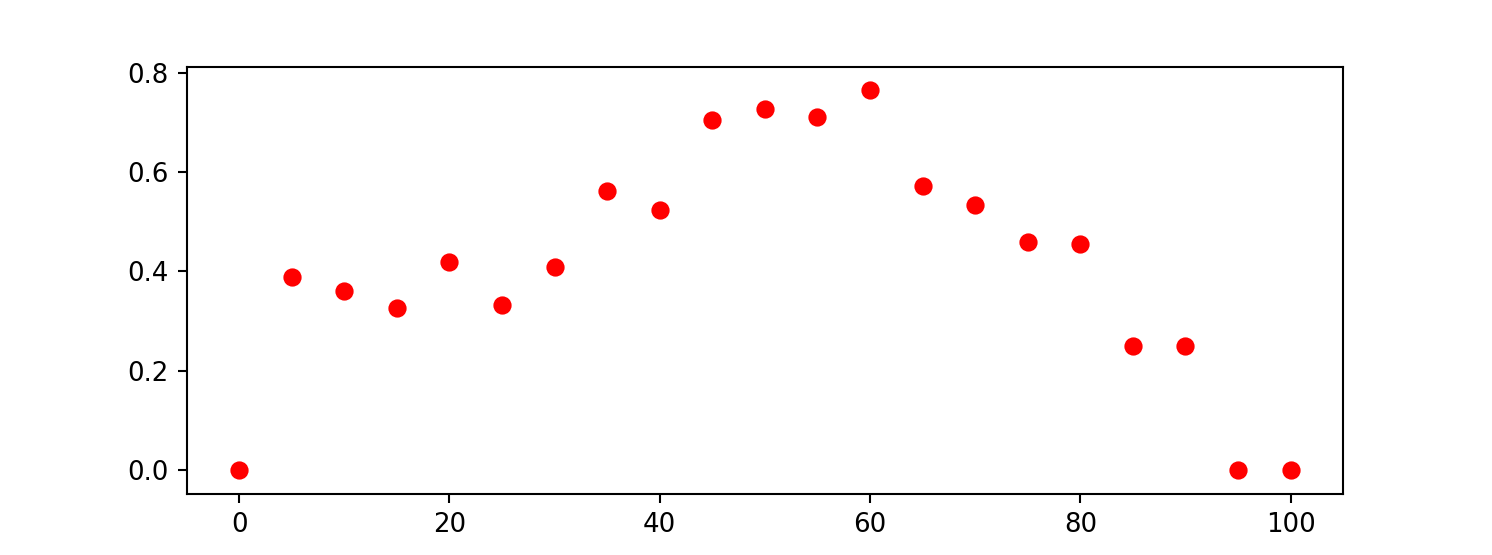

In [46]:
gamma = np.divide(sumsq, num_pairs * 2).flatten()
lag_list = np.array([i * 5 for i in range(int(100/5) + 1)])

fig = plt.figure()
ax = plt.axes()

ax.scatter(lag_list, gamma, color='red')

In [ ]:
pd.Data